<a href="https://colab.research.google.com/github/pritam5756/Predict-spike-counts-with-Linear-Gaussian-model/blob/main/LGRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Data retrieval and loading
import os
import hashlib
import requests

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# **Predict** spike counts with Linear-Gaussian **model**

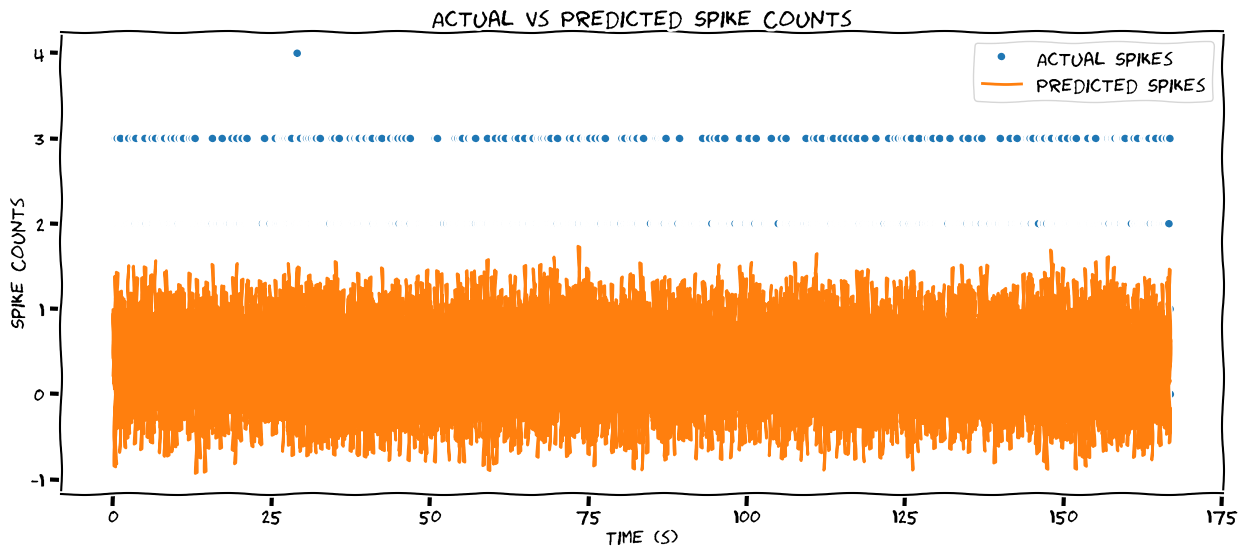

In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

def make_design_matrix(stim, d=25):
    """Create time-lag design matrix from stimulus intensity vector.

    Args:
        stim (1D array): Stimulus intensity at each time point.
        d (number): Number of time lags to use.

    Returns:
        X (2D array): GLM design matrix with shape T, d
    """
    # Create version of stimulus vector with zeros before onset
    padded_stim = np.concatenate([np.zeros(d - 1), stim])

    # Total number of timepoints (number of stimulus frames)
    T = len(stim)

    # Initialize the design matrix with zeros
    X = np.zeros((T, d))

    # Construct a matrix where each row has the d frames of
    # the stimulus preceding and including timepoint t
    for t in range(T):
        X[t] = padded_stim[t:t + d]

    return X

def predict_spike_counts_lg(stim, spikes, d=25):
    """Compute a vector of predicted spike counts given the stimulus.

    Args:
        stim (1D array): Stimulus values at each timepoint
        spikes (1D array): Spike counts measured at each timepoint
        d (number): Number of time lags to use.

    Returns:
        yhat (1D array): Predicted spikes at each timepoint.
    """
    # Create the design matrix
    y = spikes
    constant = np.ones_like(y)
    X = np.column_stack([constant, make_design_matrix(stim)])

    # Get the MLE weights for the LG model
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    # Compute predicted spike counts
    yhat = X @ theta

    return yhat

# Define the plot_spikes_with_prediction function
def plot_spikes_with_prediction(spikes, predicted_counts, dt_stim):
    time = np.arange(len(spikes)) * dt_stim
    plt.figure(figsize=(15, 6))
    plt.plot(time, spikes, label='Actual Spikes', marker='o', linestyle='None', markersize=4)
    plt.plot(time, predicted_counts, label='Predicted Spikes', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Counts')
    plt.title('Actual vs Predicted Spike Counts')
    plt.legend()
    plt.show()

# Load the data
data = loadmat('RGCdata.mat')
dt_stim = data['dtStim'].item()
stim = data['Stim'].squeeze()
cellnum = 2
spikes = data['SpCounts'][:, cellnum]

keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]

# Predict spike counts
predicted_counts = predict_spike_counts_lg(stim, spikes)

# Visualize
with plt.xkcd():
    plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)
